In [ ]:
pip install qiskit==2.0

In [ ]:
pip install qiskit_aer==0.17

In [ ]:
pip install qiskit_ibm_runtime==0.38

In [ ]:
pip install numpy==2.2

In [ ]:
pip install pylatexenc==2.10

In [ ]:
pip install matplotlib==3.9

# Chapter 13. Coding Shor and Grover's Algorithms in Qiskit

## 13.1. The QFT in Qiskit

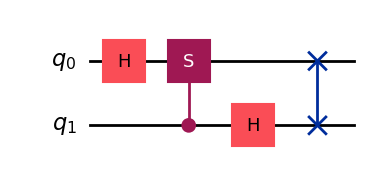

In [1]:
from qiskit import QuantumCircuit

qft2 = QuantumCircuit(2)
qft2.h(0)
qft2.cs(1,0)
qft2.h(1)
qft2.swap(0,1)
qft2.draw("mpl")

In [2]:
import numpy as np

def qft(m):
    circ_qft = QuantumCircuit(m)
    for i in range(m):
        circ_qft.h(i) # Hadamard gate
        for j in range(i+1,m):
            circ_qft.cp(np.pi/2**(j-i),j,i) # Controlled-P gates
        circ_qft.barrier()
    # Final swaps
    for i in range(m//2):
        circ_qft.swap(i,m-i-1)
    return circ_qft

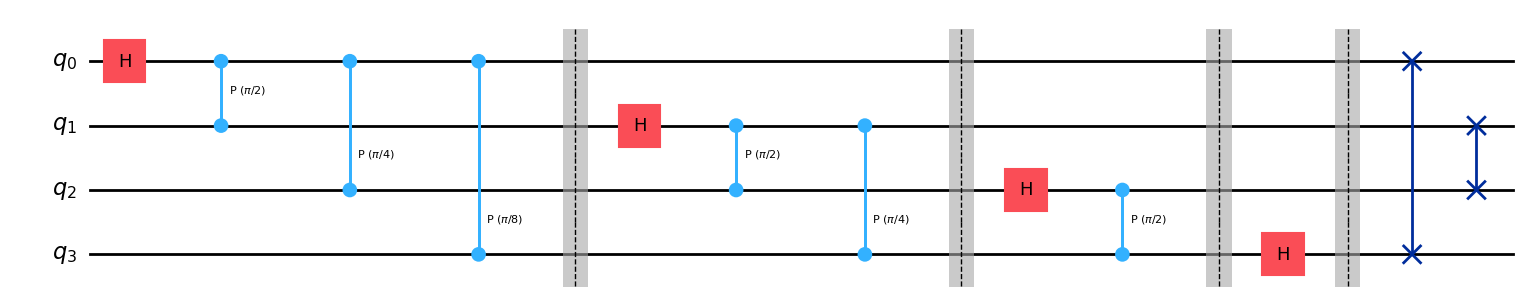

In [3]:
qft4 = qft(4)
qft4.draw("mpl")

In [4]:
def iqft(m):
    circ_iqft = QuantumCircuit(m)
    # Initial swaps
    for i in range(m//2-1,-1,-1):
        circ_iqft.swap(i,m-i-1)
    for i in range(m-1,-1,-1):
        for j in range(m-1,i,-1):
            circ_iqft.cp(-np.pi/2**(j-i),j,i) # Controlled-P gates
        circ_iqft.h(i) # Hadamard gate
        circ_iqft.barrier()
  
    return circ_iqft

## 13.2. Shor's algorithm

In [5]:
def invert(j,n): # Inverts integer j when represented with n bits
    str_j = bin(j)[2:] # Binary string for j without the leading "0b" 
    str_j = (n-len(str_j))*'0' + str_j # Pad with initial zeroes up to n bits 
    str_j = str_j[::-1] # Reverse the string
    return int(str_j,2) # Convert the string to a decimal integer 

In [6]:
from qiskit.circuit.library import UnitaryGate

def gate_mult(a,N):
    m = len(bin(N-1))-2 # Number of qubits needed to store numbers mod N
    M = 2**m

    matrix = []
    for i in range(M):
        matrix.append(M*[0]) # Initialize matrix to all zeroes

    for j in range(N):
        i = (a*j)%N # Position that we need to set to 1
        ii = invert(i,m) # Index of row for i according to Qiskit
        ij = invert(j,m) # Index of column for j according to Qiskit
        matrix[ii][ij] = 1

    for j in range(N,M):
        # Numbers bigger than N-1 are not considered, so we just leave them fixed
        ij = invert(j,m)
        matrix[ij][ij] = 1

    return UnitaryGate(matrix)

In [7]:
def circuit_shor(a,N,m):
    # a is the number we want to obtain the period of
    # N is the number to factor
    # m is the number of qubits for the upper register
  
    n = len(bin(N-1))-2 # Number of qubits needed to store numbers mod N
  
    shor = QuantumCircuit(m+n,m)
    # Upper register is of size m
    # Lower register is of size n
    # We only measure the upper register, hence m classical bits

    shor.x(m+n-1) # Set the bottom register to |1>

    for i in range(m):
        shor.h(i) # Column of Hadamard's in the upper register

    for i in range(m):
        gate = gate_mult(a**(2**i),N).control(1) # Mult by a^(2^j) mod N
        shor.append(gate,[m-i-1]+list(range(m,m+n))) # Add controlled mult

    shor.barrier()

    shor.append(iqft(m),range(m)) # Inverse QFT

    shor.barrier()

    for i in range(m):
        shor.measure(i,i) # Measure the upper register

    return shor

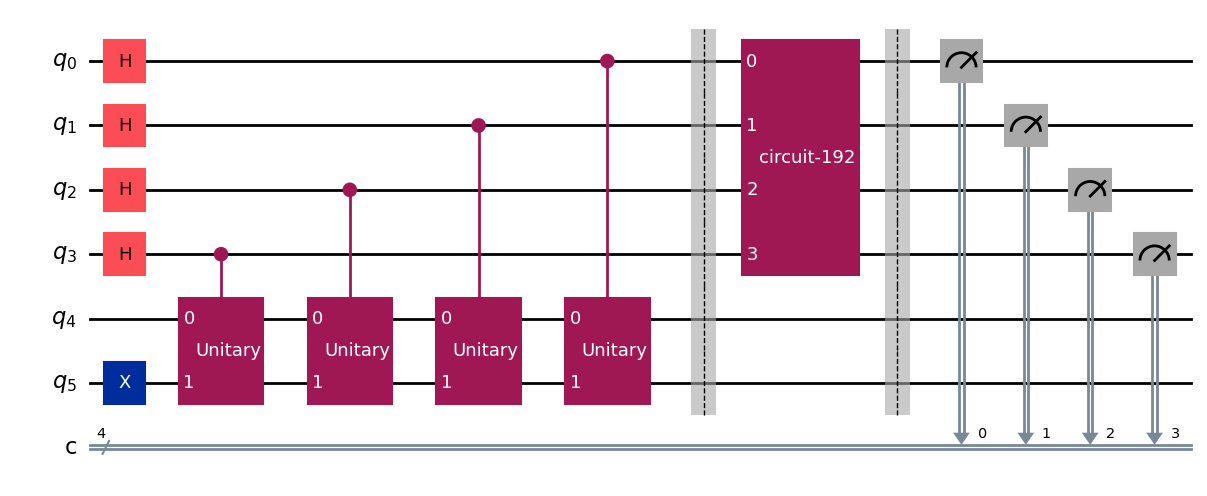

In [8]:
shor = circuit_shor(3,4,4)
shor.draw("mpl")

In [9]:
shor = circuit_shor(2,15,8)

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = AerSimulator()
sampler = Sampler(seed = 1234)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
t_shor = pm.run(shor)
job = sampler.run([t_shor], shots = 100)

In [10]:
results = job.result() # Access the results
d = results[0].data.c 
res = d.get_counts()
for k in res:
    c = int(k[::-1],2) # Reverse the string and convert it to an integer
    print("Value:",c,"Frequency:",res[k]) 

Value: 128 Frequency: 22
Value: 64 Frequency: 27
Value: 192 Frequency: 30
Value: 0 Frequency: 21


In [11]:
shor = circuit_shor(16,21,8)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
t_shor = pm.run(shor)
job = sampler.run([t_shor], shots = 100)

results = job.result() # Access the results
d = results[0].data.c 
res = d.get_counts()
for k in res:
    c = int(k[::-1],2) # Reverse the string a convert it to integer
    print("Value:",c,"Frequency:",res[k])

Value: 171 Frequency: 27
Value: 0 Frequency: 37
Value: 173 Frequency: 2
Value: 86 Frequency: 4
Value: 85 Frequency: 19
Value: 170 Frequency: 4
Value: 172 Frequency: 1
Value: 231 Frequency: 1
Value: 174 Frequency: 1
Value: 88 Frequency: 1
Value: 87 Frequency: 2
Value: 168 Frequency: 1


In [12]:
shor = circuit_shor(10,21,8)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
t_shor = pm.run(shor)
job = sampler.run([t_shor], shots = 100)

results = job.result() # Access the results
d = results[0].data.c 
res = d.get_counts()
for k in res:
    c = int(k[::-1],2) # Reverse the string a convert it to integer
    print("Value:",c,"Frequency:",res[k])

Value: 171 Frequency: 14
Value: 0 Frequency: 13
Value: 214 Frequency: 6
Value: 213 Frequency: 13
Value: 85 Frequency: 8
Value: 90 Frequency: 1
Value: 173 Frequency: 2
Value: 170 Frequency: 4
Value: 128 Frequency: 18
Value: 43 Frequency: 11
Value: 178 Frequency: 1
Value: 203 Frequency: 1
Value: 84 Frequency: 1
Value: 174 Frequency: 1
Value: 212 Frequency: 2
Value: 42 Frequency: 2
Value: 86 Frequency: 1
Value: 50 Frequency: 1


## 13.3. Grover's algorithm

In [13]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZGate

def diffusion_circuit(n):
    dc = QuantumCircuit(n)
    for i in range(n):
        dc.h(i)
        dc.x(i) 
    mcz = ZGate().control(n-1)
    dc.append(mcz, range(n))
    for i in range(n):
        dc.x(i)
        dc.h(i)
    return dc

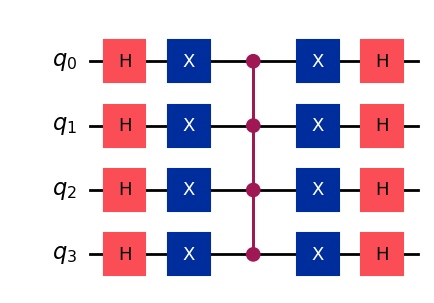

In [14]:
dc = diffusion_circuit(4)
dc.draw("mpl")

In [15]:
def build_oracle(strings_one):
    # If the function is never 1, the oracle is the identity.
    # Hence, we return an empty circuit.
    if len(strings_one) == 0:
        return QuantumCircuit()
        
    # Number of bits that the function takes as input:
    n = len(strings_one[0])
    
    qc = QuantumCircuit(n+1)
    for x in strings_one:
        # Find the positions in the string x where the bit is 0.
        # For this, we find the list of indices i such that x[i]=='0'.
        bits_zero = []
        for i in range(len(x)):
            val = x[i]
            if val == '0':
                bits_zero.append(i)

        # Step 1 in our construction.
        for bit in bits_zero:
            qc.x(bit)

        # Step 2.
        qc.mcx(list(range(n)), n)
        
        # Step 3.
        for bit in bits_zero:
            qc.x(bit)

    return qc

In [16]:
def grover_circuit(oracle, k, measure = False):
    # Number of qubits in the circuit (same as the oracle).
    # If we are working with an n-bit function, nqubits = n + 1.
    # We only measure the top qubits (hence nqubits-1 classical bits).
    nqubits = oracle.num_qubits
    qc = QuantumCircuit(nqubits,nqubits-1)

    # Set bottom qubit to |1>
    qc.x(nqubits-1) # Ancillary qubit for phase kickback
    # Apply Hadamard gates to all qubits.
    for i in range(nqubits):
        qc.h(i)

    # Apply k iterations of oracle + diffusion operator
    dc = diffusion_circuit(nqubits-1)
    qc.barrier()
    for i in range(k):  
        qc.append(oracle, range(nqubits))
        qc.barrier()
        qc.append(dc, range(nqubits-1))
        qc.barrier()

    # Measure the top qubits if so instructed
    if measure:
        qc.measure(range(nqubits-1), range(nqubits-1))

    return qc

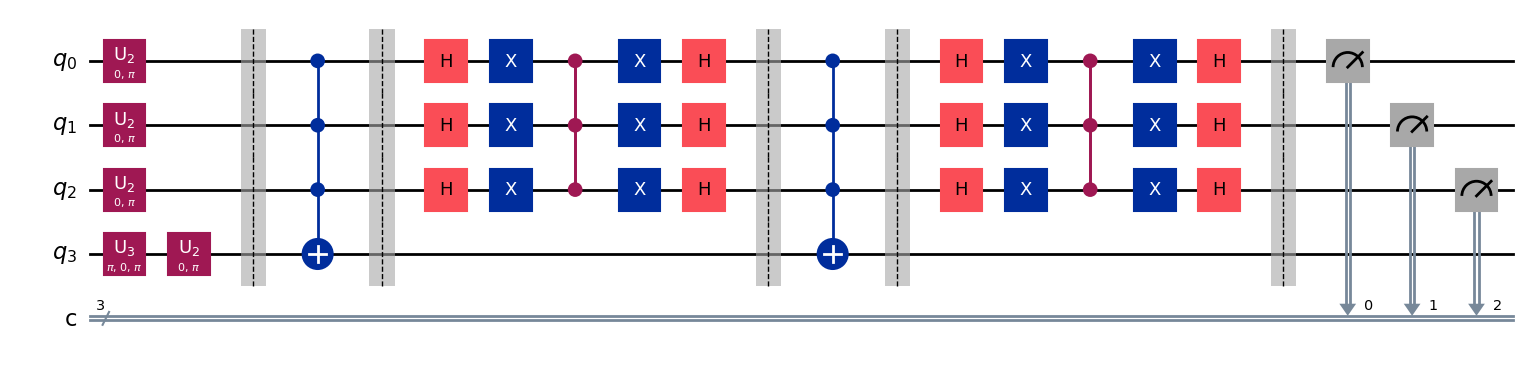

In [17]:
oracle = build_oracle(["111"])
grover = grover_circuit(oracle, 2, measure = True)
grover.decompose().draw("mpl")

In [18]:
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = Sampler(seed = 1234)
job = sampler.run([grover.decompose()], shots = 100)
results = job.result() 
d = results[0].data.c 
print(d.get_counts())

{'111': 95, '010': 1, '001': 1, '100': 1, '011': 1, '101': 1}


In [19]:
from qiskit.quantum_info import Statevector

grover = grover_circuit(oracle, 2)
sv = Statevector(grover)
print("The probability of 111 is", abs(sv['0111'])**2+abs(sv['1111'])**2)    

The probability of 111 is 0.9453124999999958
